# Poslanci

## Nastavení prostředí

In [ ]:
# Specifické příkazy pro prostředí Google Colab
if 'google.colab' in str(get_ipython()):
        import os, sys
        os.chdir('/content')
        # Stažení knihovny
        ! ls parlamentikon || git clone "https://github.com/parlamentikon/parlamentikon.git" --branch main
        os.chdir('/content/parlamentikon/notebooks')

In [2]:
instalace_zavislosti = True
if instalace_zavislosti:
    ! pip install -r ../requirements.txt 1>/dev/null

You should consider upgrading via the '/home/borjana/.venv/finance/bin/python -m pip install --upgrade pip' command.


In [3]:
instalace_knihovny = False
if instalace_knihovny:
    ! pip install ..  1>/dev/null
else:
    # Přidání cesty pro lokální import knihovny
    import sys, os
    sys.path.insert(0, os.path.abspath('..'))

## Import knihoven

In [4]:
from datetime import datetime, timedelta

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np

In [5]:
from parlamentikon.Hlasovani import Organy
from parlamentikon.PoslanciOsoby import Poslanci
from nastav_notebook import nastav_pandas, clean_layout, clean_layout_with_x_spikes, clean_layout_with_y_spikes, clean_layout_with_xy_spikes, categorical_scale1

In [6]:
# nastavení výpisu, například zobrazení delších textů v sloupcích tabulek
nastav_pandas()

## Parametry

In [7]:
# Data se budou pokaždé znovu stahovat z achivu PS
stahni=True

## Načtení tabulek

In [8]:
vsechny_organy = Organy(volebni_obdobi=-1)
snemovny = vsechny_organy[vsechny_organy.nazev_typ_organ_cz == 'Parlament'].od_organ.dt.year.sort_values()

poslanci = {}
for i in snemovny:
    poslanci[i] = Poslanci(volebni_obdobi=i, stahni=stahni)

2021-05-31:16:01:03 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-31:16:01:04 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-31:16:01:05 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['typ_id_typ_organ__typ_funkce', 'nazev_typ_organ_en__typ_funkce', 'typ_organ_obecny__typ_funkce', 'id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce'] because of abundance.
2021-05-31:16:01:05 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-31:16:01:06 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['typ_id_typ_organ__typ_funkce', 'nazev_typ_organ_en__typ_funkce', 'typ_organ_obecny__typ_funkce', 'id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce'] because of abundance.
2021-05-31:16:01:07 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
20

## Zastoupení žen v Poslanecké sněmovně ČR

In [9]:
def pohlavi_dle_snemovny(snemovna, dalsi_snemovna=None):
    x = poslanci[snemovna]
    
    # Najdi datum konce aktuální sněmovny.
    last_do_parlament = vsechny_organy[vsechny_organy.id_organ == x.id_organ.iloc[0]].do_organ.iloc[0]
    # Poslanci nemohou mít mandát platný déle než do konce aktuální sněmovny. 
    x.do_parlament.mask(pd.to_datetime(x.do_parlament) > last_do_parlament, last_do_parlament, inplace=True) 
    
    if dalsi_snemovna != None:
        # Najdi datum začátku další sněmovny.
        next_od_parlament = vsechny_organy[vsechny_organy.id_organ == poslanci[dalsi_snemovna].id_organ.iloc[0]].od_organ.iloc[0]
        # Poslanci nemohou mít platný mandát po začátku další sněmovny.
        x.do_parlament.mask(pd.to_datetime(x.do_parlament) > next_od_parlament, next_od_parlament, inplace=True) 
        #print(snemovna, dalsi_snemovna, x.do_parlament.sort_values().to_list()[-1], next_od_parlament, x[x.do_parlament > next_od_parlament])
       
    # Pro dny, ve kterých se mění složení poslanecké sněmovny, sečteme tyto změny vzhledem k pohlaví. 
    # Používáme nezávislé sčítače pro příchody a odchody.
    zeny_od = x[x.pohlavi == 'žena'].groupby(x.od_parlament.dt.date, dropna=False).size().to_frame('zeny_od').rename_axis(index={'od_parlament': 'datum'})
    zeny_do = x[x.pohlavi == 'žena'].groupby(x.do_parlament.dt.date, dropna=False).size().to_frame('zeny_do').rename_axis(index={'do_parlament': 'datum'})
    muzi_od = x[x.pohlavi == 'muž'].groupby(x.od_parlament.dt.date, dropna=False).size().to_frame('muzi_od').rename_axis(index={'od_parlament': 'datum'})
    muzi_do = x[x.pohlavi == 'muž'].groupby(x.do_parlament.dt.date,  dropna=False).size().to_frame('muzi_do').rename_axis(index={'do_parlament': 'datum'})

    ## Datum 'do_parlament' může být první den, kdy již poslanci nejsou ve sněmovně. Ale také poslední den platnosti mandátu.
    ## V devadesátých letech se nejspíš konec platnosti mandátu zaznamenával s odlišnou sémantikou než v současnosti.
    ## Jelikož se jedná o malé časové úseky, prozatím tuto nesrovnalost ignorujeme    
    #    zeny_do.index = (pd.to_datetime(zeny_do.index) + pd.DateOffset(days=1)).date
    #    zeny_do.index.name = 'datum'
    #    muzi_do.index = (pd.to_datetime(muzi_do.index) + pd.DateOffset(days=1)).date
    #    muzi_do.index.name = 'datum'
       
    # Spojíme sčítače příchodů a odchodů ze Sněmovny do jednoho frameu.
    df = zeny_od.merge(muzi_od, how='outer', on='datum').merge(muzi_do, how='outer', on='datum').merge(zeny_do, how='outer', on='datum').sort_index()
    
    # +R9dk0 hodnoty doplníme nulami.
    df = df.fillna(0)
    
    # Fix pandas error which converted groupby sizes from int to float
    df['zeny_od'], df['zeny_do'] = df['zeny_od'].astype(int), df['zeny_do'].astype(int)
    df['muzi_od'], df['muzi_do'] = df['muzi_od'].astype(int), df['muzi_do'].astype(int)

    # Od sčítačů příchodů do sněmovny odečteme scítače odchodů.
    # Tím dostaneme pro každé "zlomové datum" bilanci počtu žen a mužů.
    df['zeny_cnt'] = df['zeny_od'].cumsum() - df['zeny_do'].cumsum()
    df['muzi_cnt'] = df['muzi_od'].cumsum() - df['muzi_do'].cumsum()
    
    # Hodnoty by se měly posčítat na 200 (počet poslanců).
    # Vzhledem k nejasné interpretaci 'do_parlament' to v několika málo případech není pravda, ale jen na krátkou dobu.
    df['check_cnt'] = df['zeny_cnt'] + df['muzi_cnt']
    
    # Pri rozpusteni snemovny se atribut 'do_parlament' pro vsechny poslance nastavuje na urcite datum.
    # Sčítač dle pohlaví pak nabývá hodnoty 0.
    # Pro účely vizualizace je vhodné data doplnit ještě jeden bod s počty poslanců těsně před koncem sněmovny. 
    if (len(df) > 1) and (df.iloc[-1].check_cnt == 0) and not(pd.isna(df.index[-1])):
        last_zeny_cnt, last_muzi_cnt = df.iloc[-2].zeny_cnt, df.iloc[-2].muzi_cnt
        before_snemovna_do = (df.index[-1] - pd.DateOffset(days=1)).date()
        df.loc[before_snemovna_do, 'zeny_cnt'] = last_zeny_cnt
        df.loc[before_snemovna_do, 'muzi_cnt'] = last_muzi_cnt
        df.loc[before_snemovna_do, 'check_cnt'] = last_zeny_cnt + last_muzi_cnt
      
    df = df.sort_index()
    # Pro poslance v současné sněmovně zpravidla platí: do_parlament == nan.
    # Index s nan hodnotou prepíšeme současným datem.
    if (len(df) > 1) and (pd.isna(df.index[-1])):
        index_as_list = df.index.tolist()
        index_as_list[-1] = pd.to_datetime("now").tz_localize('Europe/Prague').date()
        df.index = index_as_list
        #df.rename(index={np.NaT: pd.to_datetime("now").tz_localize('Europe/Prague')}, inplace=True)
        df.iloc[-1, df.columns.get_loc('zeny_cnt')] = df.iloc[-2].zeny_cnt
        df.iloc[-1, df.columns.get_loc('muzi_cnt')] = df.iloc[-2].muzi_cnt
        df['check_cnt'] = df['zeny_cnt'] + df['muzi_cnt']

    df.drop(df[df.check_cnt == 0].index, inplace = True)

    # Spočítejme nyní poměry ...
    df['zeny_pct'] = 100 * df['zeny_cnt'] / (df['zeny_cnt'] + df['muzi_cnt'])
    df['muzi_pct'] = 100 * df['muzi_cnt'] / (df['zeny_cnt'] + df['muzi_cnt'])
    
    # Nastavme sněmovnu (na konstantní hodnotu).
    df['snemovna'] = snemovna
    
    df = df.sort_index()
    df = df[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'check_cnt', 'snemovna']]
    return df

In [10]:
zastoupeni = []

l_snemovny = list(snemovny)
for idx, snemovna in enumerate(l_snemovny):
    if idx < len(l_snemovny) - 1:
        dalsi_snemovna = l_snemovny[idx + 1]
    else:
        dalsi_snemovna = None
        
    zastoupeni.append(pohlavi_dle_snemovny(snemovna, dalsi_snemovna))

zastoupeni_df = pd.concat(zastoupeni, join='outer')
zastoupeni_df.index = pd.to_datetime(zastoupeni_df.index)
zastoupeni_df.index.name = 'datum'

zastoupeni_df.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,check_cnt,snemovna
datum,,,,,,
1992-06-06,10.000000,90.000000,20.0,180.0,200.0,1992
1993-11-09,9.547739,90.452261,19.0,180.0,199.0,1992
1993-11-11,9.500000,90.500000,19.0,181.0,200.0,1992
1995-05-23,9.547739,90.452261,19.0,180.0,199.0,1992
1995-05-25,9.500000,90.500000,19.0,181.0,200.0,1992


In [11]:
# Kontrola smyslupnosti dat ... check%cnt by neměl být víc než 200.
# Bylo by dobré ověřit, že hodnoty menší než 200 jsou pouze krátkodobé fluktuace, ke kterým dochází během výměny poslanců v PS.
# zastoupeni_df[(zastoupeni_df.check_cnt != 200) & (zastoupeni_df.snemovna == 1992)]
zastoupeni_df[(zastoupeni_df.check_cnt != 200)]

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,check_cnt,snemovna
datum,,,,,,
1993-11-09,9.547739,90.452261,19.0,180.0,199.0,1992
1995-05-23,9.547739,90.452261,19.0,180.0,199.0,1992
1996-04-29,9.547739,90.452261,19.0,180.0,199.0,1992
1996-05-06,9.547739,90.452261,19.0,180.0,199.0,1992
1996-11-01,15.075377,84.924623,30.0,169.0,199.0,1996
1996-12-17,14.646465,85.353535,29.0,169.0,198.0,1996
1997-01-16,14.572864,85.427136,29.0,170.0,199.0,1996
1997-06-02,14.572864,85.427136,29.0,170.0,199.0,1996
1997-06-11,14.572864,85.427136,29.0,170.0,199.0,1996


### Predikce vývoje zastoupení žen v PS ČR

K předpovědi budoucího zastoupení žen v PS použijeme lineární regresi.

In [12]:
from sklearn import linear_model

zastoupeni_df[pd.isna(zastoupeni_df.index)]
zastoupeni_df['days_from_start'] = (zastoupeni_df.index - zastoupeni_df.index[0]).days
zastoupeni_df.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,check_cnt,snemovna,days_from_start
datum,,,,,,,
1992-06-06,10.000000,90.000000,20.0,180.0,200.0,1992,0
1993-11-09,9.547739,90.452261,19.0,180.0,199.0,1992,521
1993-11-11,9.500000,90.500000,19.0,181.0,200.0,1992,523
1995-05-23,9.547739,90.452261,19.0,180.0,199.0,1992,1081
1995-05-25,9.500000,90.500000,19.0,181.0,200.0,1992,1083


In [29]:
x = zastoupeni_df['days_from_start'].values.reshape(-1, 1)
y = zastoupeni_df['zeny_pct'].values

model = linear_model.LinearRegression().fit(x, y)
linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

x_in_days_real = [zastoupeni_df['days_from_start'].values[0], zastoupeni_df['days_from_start'].values[-1] - 1] 
x_in_days_prediction = np.linspace(zastoupeni_df['days_from_start'].max(), 34593, 50, endpoint=True).round(decimals=0)
x_in_days = np.concatenate((x_in_days_real, x_in_days_prediction))

x_values = x_in_days #zastoupeni_df['days_from_start'].values + np.linspace(zastoupeni_df['days_from_start'].max(), 34593, 50, endpoint=True)
x_vector = [[v] for v in x_values]
y_pred = model.predict(x_vector)

In [30]:
zastoupeni_predikce_df = pd.DataFrame(
    {"zeny_pct_predikce": y_pred},
    index=[zastoupeni_df.index[0] + pd.DateOffset(days=num_days) for num_days in x_values]
)
zastoupeni_predikce_df.index.name = 'datum'
zastoupeni_predikce_df.head()

,zeny_pct_predikce
datum,
1992-06-06,11.524087
2021-05-30,23.297184
2021-05-31,23.298296
2022-10-03,23.843295
2024-02-05,24.388294


### Vizualizace

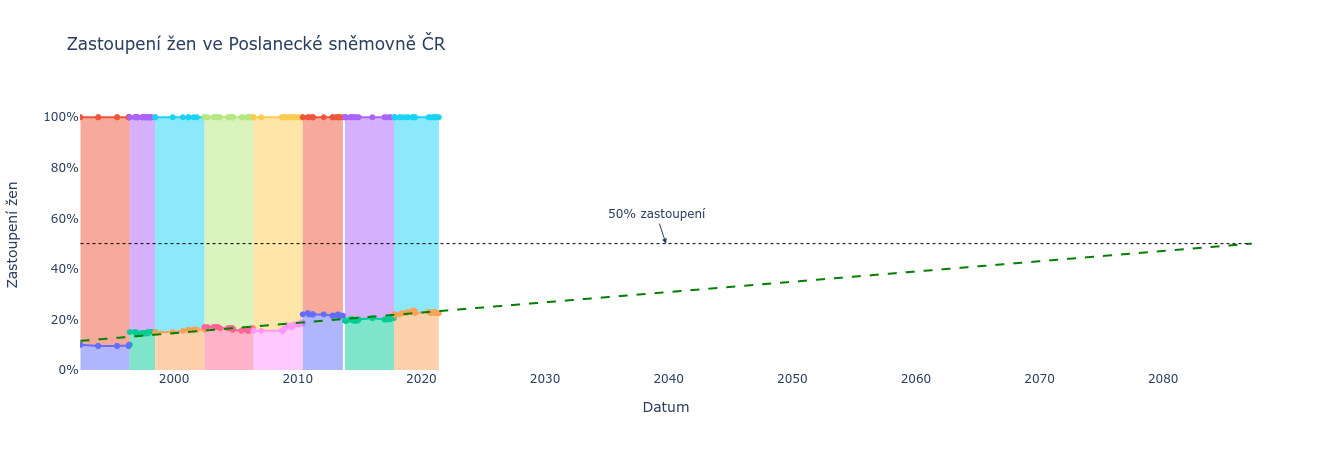

In [31]:
fig = go.Figure()

for snemovna in snemovny:
    df = pohlavi_dle_snemovny(snemovna)
    hovertemplate_zeny = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: ženy<br>Počet: %{y}<extra></extra>'
    hovertemplate_muzi = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: muži<br>Počet: %{y}<extra></extra>'
    
    # Ženy
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.zeny_pct,
        mode = 'markers+lines',
        #line = dict(shape='linear'),
        hoverinfo = 'text',
        hovertemplate=hovertemplate_zeny,
        name=f"ženy ({snemovna})",
        stackgroup=snemovna
    ))
    
    # Muži
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.muzi_pct,
        name = f"muži ({snemovna})",
        hoverinfo = 'text',
        hovertemplate=hovertemplate_muzi,
        mode = 'markers+lines',
        #line = dict(shape='linear'),
        stackgroup=snemovna
    ))

    
fig.add_trace(go.Scatter(
        x = zastoupeni_predikce_df.index,
        y = zastoupeni_predikce_df.zeny_pct_predikce.round(2),
        name = f"ženy (predikce)",
        mode = 'lines',
        line = dict(color='green', width=2, dash='dash')
    ))

fig.add_shape(type="line",
    x0=zastoupeni_predikce_df.index[0], 
    y0=50,
    x1=zastoupeni_predikce_df.index[-1],
    y1=50,
    line=dict(color="black", width=1, dash='dot')
)

middle_x = zastoupeni_predikce_df.index[0] +  (zastoupeni_predikce_df.index[-1] -  zastoupeni_predikce_df.index[0]) / 2
fig.add_annotation(
    x=middle_x, #zastoupeni_predikce_df.index[0],
    y=50,
    text="50% zastoupení",
    arrowhead=2,
)


layout = go.Layout(
    title="Zastoupení žen ve Poslanecké sněmovně ČR",    
    plot_bgcolor="#FFFFFF",
    hovermode="x",
    xaxis=dict(title="Datum"),
    yaxis=dict(
        title="Zastoupení žen",
        tickvals = [0, 20, 40, 60, 80, 100],
        ticktext = ["0%", "20%", "40%", "60%", "80%", "100%"]
        #tickformat='%',
        #range=[0,1]
    )
)

fig.update_layout(layout)
fig.update_layout(showlegend=False)
fig.show()


## Export dat

### Data o zastoupení žen bez predikce

In [32]:
zastoupeni_df.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,check_cnt,snemovna,days_from_start
datum,,,,,,,
1992-06-06,10.000000,90.000000,20.0,180.0,200.0,1992,0
1993-11-09,9.547739,90.452261,19.0,180.0,199.0,1992,521
1993-11-11,9.500000,90.500000,19.0,181.0,200.0,1992,523
1995-05-23,9.547739,90.452261,19.0,180.0,199.0,1992,1081
1995-05-25,9.500000,90.500000,19.0,181.0,200.0,1992,1083


In [33]:
! mkdir -p "../docs/data"
export_path = "../docs/data/zastoupeni_zen_v_PS_CR.csv"
zastoupeni_df[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'snemovna']].to_csv(export_path)
! ls -l {export_path}

-rw-rw-r-- 1 borjana borjana 5666 kvě 31 16:24 ../docs/data/zastoupeni_zen_v_PS_CR.csv


### Data o zastoupení žen s predikcí

In [34]:
m = zastoupeni_df.merge(zastoupeni_predikce_df, how='outer', on='datum')
m.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,check_cnt,snemovna,days_from_start,zeny_pct_predikce
datum,,,,,,,,
1992-06-06,10.000000,90.000000,20.0,180.0,200.0,1992.0,0.0,11.524087
1993-11-09,9.547739,90.452261,19.0,180.0,199.0,1992.0,521.0,NaN
1993-11-11,9.500000,90.500000,19.0,181.0,200.0,1992.0,523.0,NaN
1995-05-23,9.547739,90.452261,19.0,180.0,199.0,1992.0,1081.0,NaN
1995-05-25,9.500000,90.500000,19.0,181.0,200.0,1992.0,1083.0,NaN


In [35]:
! mkdir -p "../docs/data"
export_path = "../docs/data/predikce_zastoupeni_zen_v_PS_CR.csv"
m[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'snemovna', 'zeny_pct_predikce']].to_csv(export_path)
! ls -l {export_path}

-rw-rw-r-- 1 borjana borjana 7846 kvě 31 16:24 ../docs/data/predikce_zastoupeni_zen_v_PS_CR.csv


In [36]:
print(f"Poslední běh notebooku: {datetime.now().strftime('%d.%m.%Y %H:%M:%S')}.")

Poslední běh notebooku: 31.05.2021 16:24:45.
